## Predict Health Insurance Owners who will be interested in Vehicle Insurance
Building a model to predict whether a customer would be interested in Vehicle Insurance, so that company can accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue.

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

#### Data Description

### Import Libraries

In [105]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas_profiling

import xgboost
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score


### The Data

In [47]:
data = pd.read_csv("train.csv")
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [48]:
data.shape

(381109, 12)

In [49]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


### Exploratory Data Analysis

#### Sampling

In [76]:
#Get random sample of 60% of data set
df = data.sample(frac = 0.3, random_state = 1, replace = False)
# df.reset_index(drop = True, inplace = True)
df.head()
df.shape

(114333, 11)

In [ ]:
df["Response"].value_counts()

#### --------------------

In [78]:
report = data.profile_report()
report.to_file("report.html")

In [79]:
data["Response"].value_counts()

0    334399
1     46710
Name: Response, dtype: int64

In [50]:
data.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

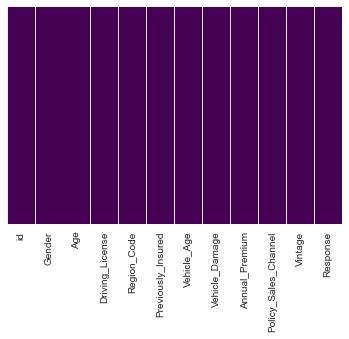

In [51]:
sns.heatmap(data.isnull(),yticklabels=False, cbar =False, cmap='viridis')

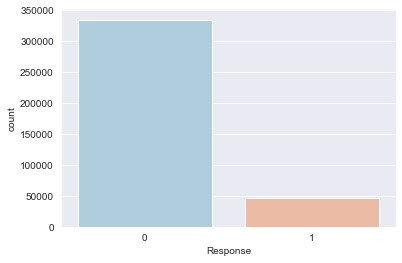

In [67]:
sns.set_style("darkgrid")
sns.countplot(data["Response"],palette='RdBu_r')

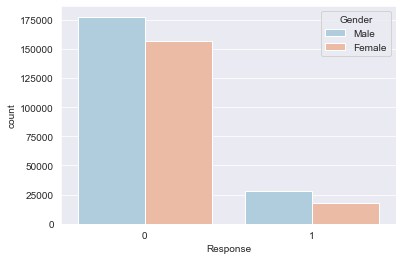

In [53]:
sns.countplot("Response", hue = "Gender", data = data, palette='RdBu_r')

In [54]:
data.nunique()

id                      381109
Gender                       2
Age                         66
Driving_License              2
Region_Code                 53
Previously_Insured           2
Vehicle_Age                  3
Vehicle_Damage               2
Annual_Premium           48838
Policy_Sales_Channel       155
Vintage                    290
Response                     2
dtype: int64

In [55]:
data["Vehicle_Age"].value_counts()

1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64

In [56]:
data["Response"].value_counts()

0    334399
1     46710
Name: Response, dtype: int64

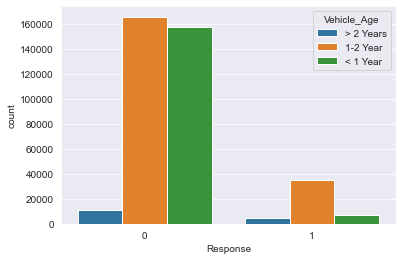

In [57]:
sns.countplot("Response", hue = "Vehicle_Age", data = data)

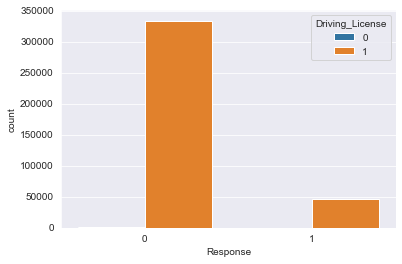

In [58]:
sns.countplot("Response", hue = "Driving_License", data = data)

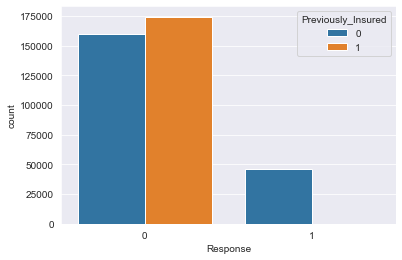

In [59]:
sns.countplot("Response", hue = "Previously_Insured", data = data)

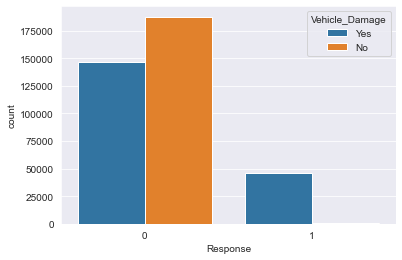

In [60]:
sns.countplot("Response", hue = "Vehicle_Damage", data = data)

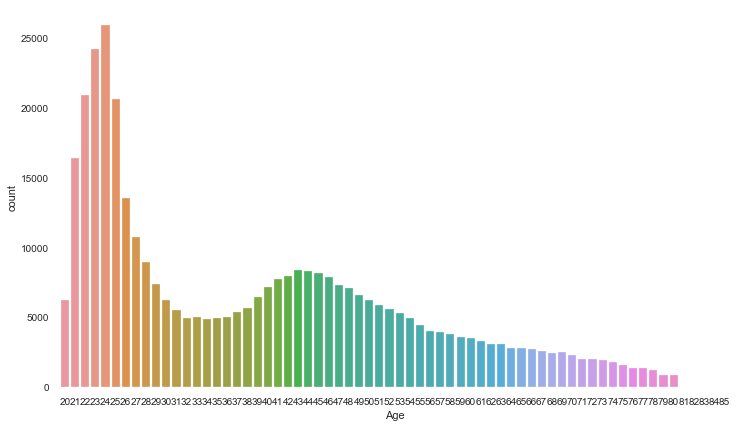

In [80]:
plt.figure(figsize=(12, 7))
sns.countplot(data["Age"])

In [70]:
data[["Policy_Sales_Channel","Region_Code"]].nunique()

Policy_Sales_Channel    155
Region_Code              53
dtype: int64

In [83]:
data.duplicated().sum()

269

In [85]:
data[data.duplicated(keep=False)]

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
1116,1,61,1,28.0,1,1,0,2630.0,26.0,226,0
2142,1,24,1,29.0,0,0,1,2630.0,152.0,152,0
2567,1,38,1,13.0,0,1,1,2630.0,124.0,220,1
6178,0,25,1,33.0,1,0,0,2630.0,152.0,168,0
6276,1,26,1,7.0,1,0,0,2630.0,152.0,100,0
...,...,...,...,...,...,...,...,...,...,...,...
379273,0,58,1,30.0,1,1,0,2630.0,152.0,150,0
379451,0,41,1,30.0,0,1,1,2630.0,156.0,111,0
379788,0,38,1,28.0,1,1,0,2630.0,124.0,42,0
380673,1,37,1,28.0,0,1,1,2630.0,156.0,176,0


In [86]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

In [88]:
data["Response"].value_counts()

0    334155
1     46685
Name: Response, dtype: int64

### Converting Categorical Features

In [62]:
data.replace({"Gender":{"Male":0, "Female":1}, "Vehicle_Age":{"< 1 Year":0, "1-2 Year":1, "> 2 Years":2}, \
                        "Vehicle_Damage":{"No":0, "Yes":1}}, inplace = True)

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  int64  
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  int64  
 7   Vehicle_Damage        381109 non-null  int64  
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 34.9 MB


In [64]:
data.drop(["id"],inplace=True, axis = 1)
data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,0,76,1,3.0,0,1,0,33536.0,26.0,183,0
2,0,47,1,28.0,0,2,1,38294.0,26.0,27,1
3,0,21,1,11.0,1,0,0,28619.0,152.0,203,0
4,1,29,1,41.0,1,0,0,27496.0,152.0,39,0


In [89]:
#grouping Age


### Scaling and Encoding

In [90]:
data = pd.get_dummies(data, columns=["Vehicle_Age"],drop_first=True)
data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_1,Vehicle_Age_2
0,0,44,1,28.0,0,1,40454.0,26.0,217,1,0,1
1,0,76,1,3.0,0,0,33536.0,26.0,183,0,1,0
2,0,47,1,28.0,0,1,38294.0,26.0,27,1,0,1
3,0,21,1,11.0,1,0,28619.0,152.0,203,0,0,0
4,1,29,1,41.0,1,0,27496.0,152.0,39,0,0,0


### Scaling

In [94]:
sc = StandardScaler()
X = sc.fit_transform(data.drop("Response", axis =1))
y = data["Response"]

X[:10]

array([[-0.92157173,  0.33367791,  0.04622429,  0.12182208, -0.91963436,
         0.99029496,  0.57372833, -1.58709424,  0.74883824, -1.05256667,
         4.77488482],
       [-0.92157173,  2.39643927,  0.04622429, -1.7678385 , -0.91963436,
        -1.00980015,  0.17159469, -1.58709424,  0.34248056,  0.95005859,
        -0.20942914],
       [-0.92157173,  0.52706179,  0.04622429,  0.12182208, -0.91963436,
         0.99029496,  0.44817056, -1.58709424, -1.52198409, -1.05256667,
         4.77488482],
       [-0.92157173, -1.14893181,  0.04622429, -1.16314711,  1.08738869,
        -1.00980015, -0.11422363,  0.73736642,  0.58151449, -1.05256667,
        -0.20942914],
       [ 1.08510273, -0.63324147,  0.04622429,  1.10444558,  1.08738869,
        -1.00980015, -0.17950205,  0.73736642, -1.37856373, -1.05256667,
        -0.20942914],
       [ 1.08510273, -0.95554793,  0.04622429,  0.49975419, -0.91963436,
         0.99029496, -1.62492777,  0.88495122,  0.25881869, -1.05256667,
        -0.209

### Train Test Split

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### Modelling

#### Logistic Regression

In [96]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_test)

In [98]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93    100282
           1       0.17      0.00      0.00     13970

    accuracy                           0.88    114252
   macro avg       0.52      0.50      0.47    114252
weighted avg       0.79      0.88      0.82    114252



In [109]:
accuracy_score(y_test, pred)

0.8776914189685957

#### Decision Tree

In [99]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
dt_pred = dt.predict(X_test)

In [100]:
print(classification_report(y_test,dt_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90    100282
           1       0.29      0.31      0.30     13970

    accuracy                           0.82    114252
   macro avg       0.60      0.60      0.60    114252
weighted avg       0.83      0.82      0.83    114252



In [108]:
accuracy_score(y_test, dt_pred)

0.8232241011098274

#### Random Forest

In [102]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)

In [103]:
print(classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93    100282
           1       0.37      0.12      0.18     13970

    accuracy                           0.87    114252
   macro avg       0.63      0.55      0.55    114252
weighted avg       0.82      0.87      0.84    114252



In [107]:
accuracy_score(y_test, rf_pred)

0.8669344956762245

#### XGBoost

In [110]:
xgb = XGBClassifier(max_depth= 2, eta= 1, objective= 'binary:logistic')
xgb.fit(X_train,y_train)
xgb_pred = xgb.predict(X_test)

In [111]:
print(classification_report(y_test,xgb_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93    100282
           1       0.49      0.03      0.05     13970

    accuracy                           0.88    114252
   macro avg       0.69      0.51      0.49    114252
weighted avg       0.83      0.88      0.83    114252



In [112]:
accuracy_score(y_test, xgb_pred)

0.877656408640549

### Hyperparameter Tuning - RF

In [115]:
# param_grid = {
#     'max_depth': [10,15],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [3,4,5],
#     'n_estimators': [100, 200]
# }
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)

# # Fit the grid search to the data
# grid_search.fit(X_train,y_train)
# grid_search.best_estimator_

In [116]:
data.to_pickle("df.pkl")